<a href="https://colab.research.google.com/github/AMX07/makemore/blob/main/makemore_1_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bigram Language model using Stats counting.


In [ ]:
# # HW
# E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
# E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
# E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
# E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?
# E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?
# E06: meta-exercise! Think of a fun/interesting exercise and complete it.

# Yes it did improve over bigram, better loss and better sampling
#

In [1]:
#prepare the dataset

words = open('names.txt', 'r').read().splitlines() # store all the names in the words variable as a list of strings of names

# words[:10]

# ['emma',
#  'olivia',
#  'ava',
#  'isabella',
#  'sophia',
#  'charlotte',
#  'mia',
#  'amelia',
#  'harper',
#  'evelyn']


# start counting and store counts for bigrams in table

# b = {}
# for w in words:
#   chs = ['<S>'] + list(w) + ['<E>']
#   for ch1, ch2 in zip(chs, chs[1:]):
#     bigram = (ch1, ch2)
#     b[bigram] = b.get(bigram, 0) + 1


# this is fine, but we can move towards something more effcient by storing our data as tesnors

import torch

N = torch.zeros((27, 27), dtype=torch.int32) # initiale a 2-D tensor (table)


# count and store

# we will store the index instead of strings directly, we need a mapping for string <> index (stoi and itos)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

# Now we can start counting and storing
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.figure(figsize=(16,16))
# plt.imshow(N, cmap='Blues')
# for i in range(27):
#     for j in range(27):
#         chstr = itos[i] + itos[j]
#         plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
#         plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
# plt.axis('off');

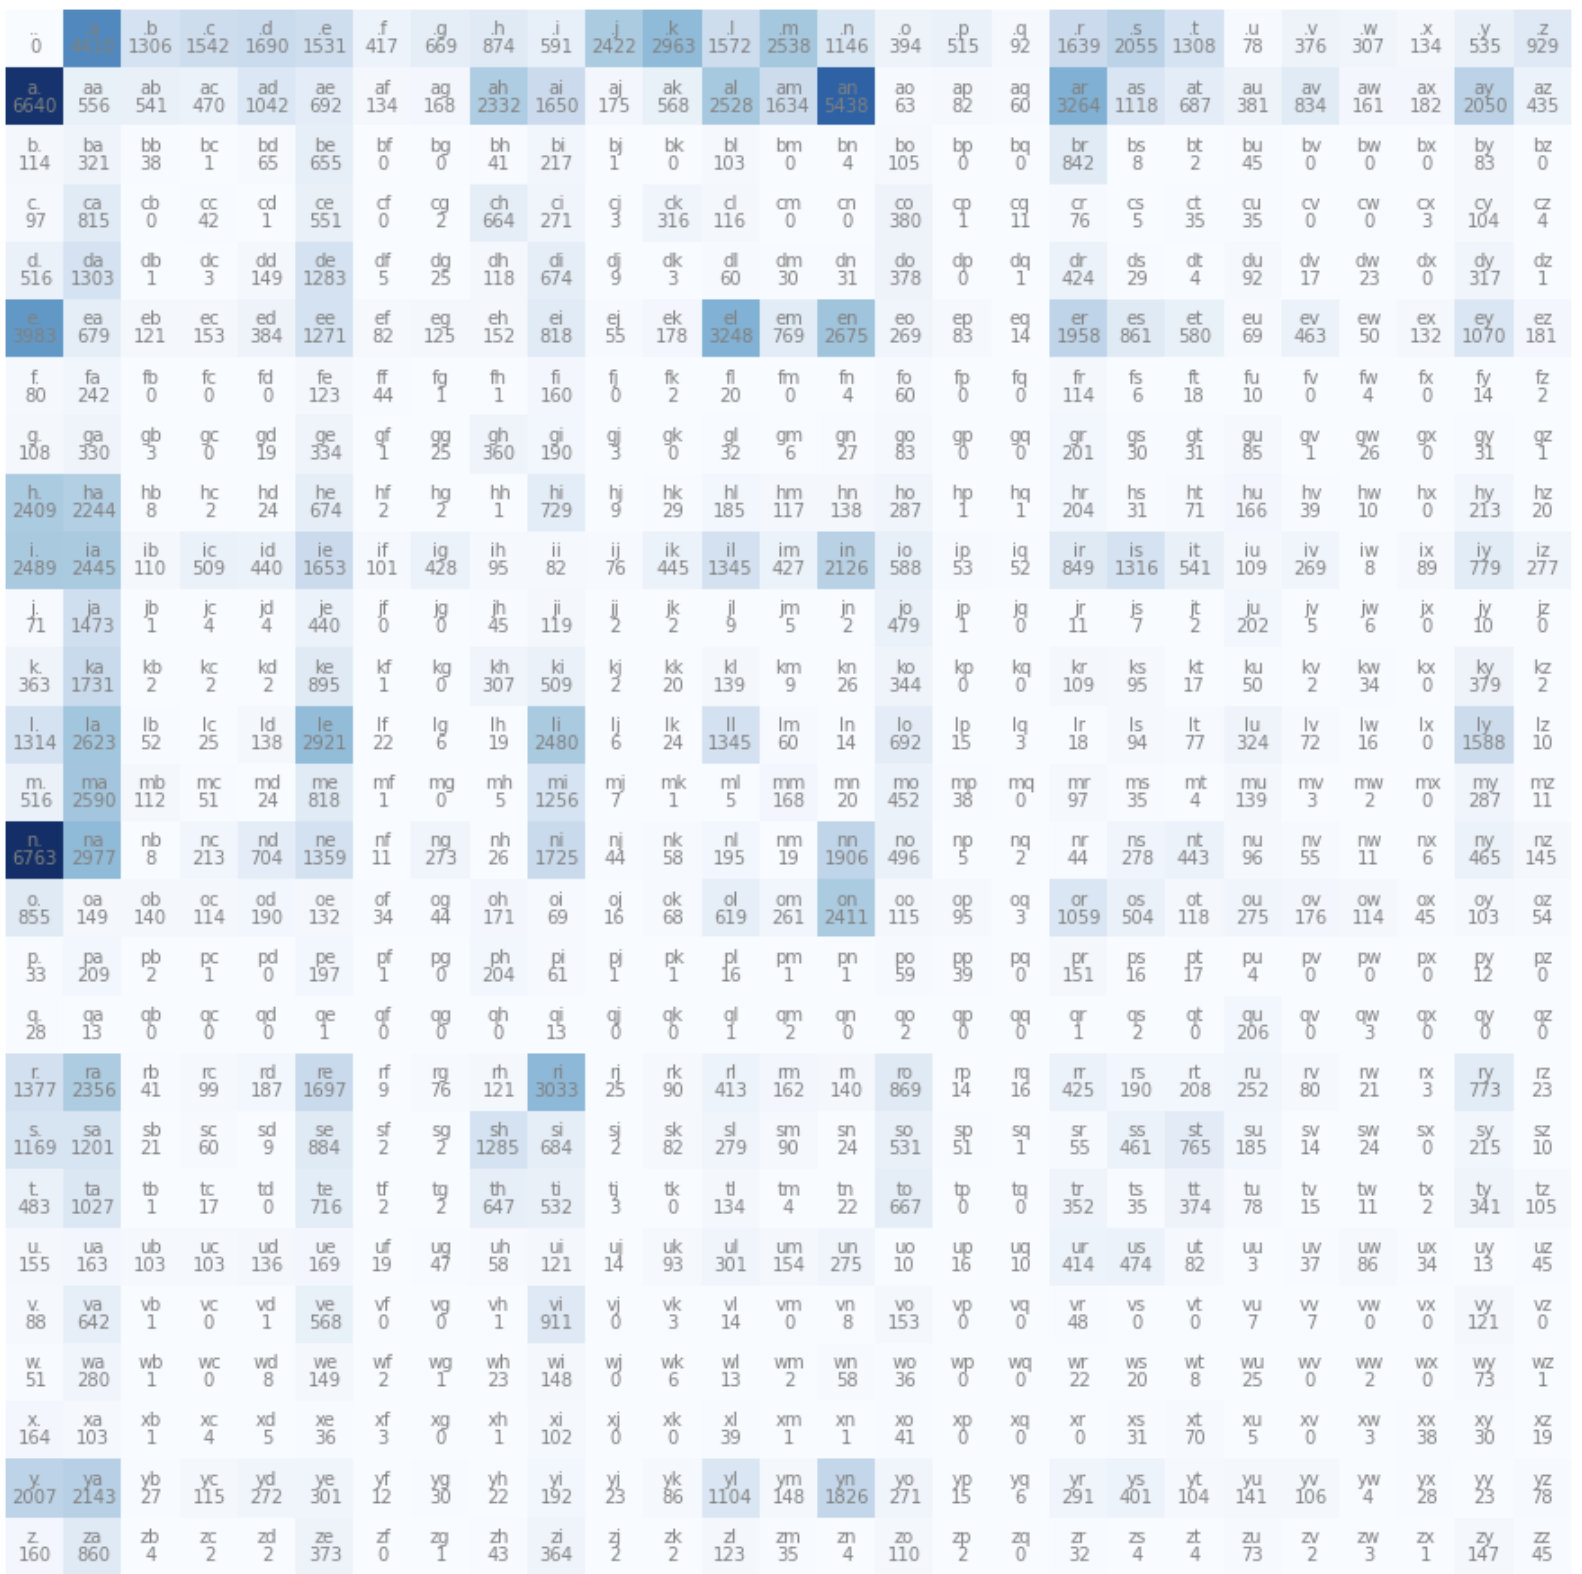

In [ ]:
# now we will start sampling!

P = (N+1).float() # the plus 1 is for smoothing, i.e taking care of rare events that are not caputred in our training data but can occur
P /= P.sum(1, keepdims=True)


g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))


# mor.
# axx.
# minaymoryles.
# kondlaisah.
# anchshizarie.

In [ ]:

# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)


log_likelihood = 0.0
n = 0

for w in words:
#for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')


# log_likelihood=tensor(-564996.8125, grad_fn=<AddBackward0>)
# nll=tensor(564996.8125, grad_fn=<NegBackward0>)
# 2.476470470428467


In [ ]:
# now we move on to NN !!!



# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)




# gradient descent
for k in range(1):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad



# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:

    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))


# mor.
# axx.
# minaymoryles.
# kondlaisah.
# anchthizarie.


In [2]:
# E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one.
# Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

import torch
import torch.nn.functional as F

In [3]:
#E02
n = torch.randperm(len(words))
n_train = int(0.8*len(words))
n_dev = int(0.1*len(words))

train = [words[i] for i in n[:n_train]]
dev = [words[i] for i in n[n_train:n_train+n_dev]]
test = [words[i] for i in n[n_train+n_dev:]]





In [4]:
#traing a trigram model with regularization


# gotta create dataset!
x1 = []
x2 = []
y  = []

for w in train:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs,chs[1:],chs[2:]):
    x1.append(stoi[ch1])
    x2.append(stoi[ch2])
    y.append(stoi[ch3])

x1 = torch.tensor(x1) #dtype is int
x2 = torch.tensor(x2)
# do we need y to be a tensor? Yes!!
y = torch.tensor(y)
n1 = x1.nelement()
print(x2.nelement())
# do we need n2? nope



# one_hot_encoding for representations!
x1enc = F.one_hot(x1,27)
x2enc = F.one_hot(x2,27)

#gotta concat them!
xenc = torch.cat((x1enc,x2enc),dim=1).float() # shape 156807 x 54


# initate W and g

g = torch.Generator().manual_seed(214783647)


156972


In [12]:
# forward pass
W = torch.rand((54,27),generator=g,dtype=torch.float,requires_grad=True)
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(dim=1,keepdim=True)
loss = - probs[torch.arange(n1),y].log().mean()
print(loss)
F.cross_entropy(logits,y)
#why use cross_entropy? simpler/ conviniece : one function instead exp,normalizing, calculating loss, less scope of mistakes with broadcasting
# mathematically same as exp,probs,loss
#



tensor(3.3026, grad_fn=<NegBackward0>)


tensor(3.3026, grad_fn=<NllLossBackward0>)

In [ ]:
# Training the model
for reg_st in [1,0.1,0.001,0.0001,0.000001,0.0000001,0.00000001]:
  W = torch.rand((54,27),generator=g,dtype=torch.float,requires_grad=True)
  print("reg_st loss_train loss_dev")
  for k in range(500):
    # forward pass
    logits = xenc @ W
    # counts = logits.exp()
    # probs = counts/counts.sum(dim=1,keepdim=True)
    F.cross_entropy(logits,y)
    loss = - probs[torch.arange(n1),y].log().mean() + reg_st * (W**2).mean()
    # print(loss.data)

    #backward pass
    W.grad = None
    loss.backward()

    #update the parameters
    W.data += - 50 * W.grad

    #final loss approx 2.2529



  logits_dev = xenc_dev @ W
  counts_dev = logits_dev.exp()
  probs_dev = counts_dev/counts_dev.sum(dim=1,keepdim=True)
  loss_dev = - probs_dev[torch.arange(n_dev),y_dev].log().mean()
  print(reg_st, loss,loss_dev)



In [ ]:
for i in range(5):
  out = []
  x1 = 0
  x2 = 0
  while True:
    # print(out)
    x1enc = F.one_hot(torch.tensor([x1]),num_classes=27)
    x2enc = F.one_hot(torch.tensor([x2]),num_classes=27)
    xenc = torch.cat((x1enc,x2enc),dim=1).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/counts.sum(dim=1,keepdim=True)
    x3 = torch.multinomial(probs,num_samples=1, replacement=True,generator=g).item()
    if x3 == 0:
      break
    out.append(itos[x3])
    x1,x2 = x2,x3
  print("".join(out))
